<a href="https://colab.research.google.com/github/Malwina9912/Uczenie-maszynowe-/blob/main/Case3_Malwina%20Pawlicka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtesting
!pip install yfinance
!pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=1cc6eb126718ffcad1d13bbe1c63c236152ff10d59c1e0dabbd5c1fefe76c305
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from backtesting import Backtest, Strategy
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [3]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


In [4]:
# Pobieranie danych
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
data['Return'] = data['Close'].pct_change()
data.dropna(inplace=True)

# Tworzenie cech
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = calculate_rsi(data['Close'])

data.dropna(inplace=True)


[*********************100%%**********************]  1 of 1 completed


In [5]:
# Przygotowanie danych do modelu
features = ['SMA_10', 'SMA_50', 'RSI']
X = data[features]
y = np.where(data['Return'] > 0, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Parametry do optymalizacji
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20]
}

# Optymalizacja
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Najlepsze parametry: ", grid_search.best_params_)
best_model = grid_search.best_estimator_


Najlepsze parametry:  {'max_depth': 5, 'n_estimators': 200}


In [7]:
data['Signal'] = best_model.predict(X)
data['Position'] = data['Signal'].diff()


In [8]:
# Filtr danych dla okresu testowego
test_data = yf.download('AAPL', start='2024-01-01', end='2024-05-06')
test_data['Return'] = test_data['Close'].pct_change()
test_data.dropna(inplace=True)

# Generowanie sygnałów dla danych testowych
test_data['SMA_10'] = test_data['Close'].rolling(window=10).mean()
test_data['SMA_50'] = test_data['Close'].rolling(window=50).mean()
test_data['RSI'] = calculate_rsi(test_data['Close'])
test_data.dropna(inplace=True)

test_features = test_data[['SMA_10', 'SMA_50', 'RSI']]
test_data['Signal'] = best_model.predict(test_features)
test_data['Position'] = test_data['Signal'].diff()

class MLStrategy(Strategy):
    def init(self):
        self.signal = self.data['Signal']

    def next(self):
        if self.signal == 1:
            self.buy()
        elif self.signal == -1:
            self.sell()

bt = Backtest(test_data, MLStrategy, cash=10000, commission=.002)
stats = bt.run()
bt.plot()

print(stats)


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2024-03-14 00:00:00
End                       2024-05-03 00:00:00
Duration                     50 days 00:00:00
Exposure Time [%]                   94.444444
Equity Final [$]                 10396.791223
Equity Peak [$]                  10396.791223
Return [%]                           3.967912
Buy & Hold Return [%]                6.000003
Return (Ann.) [%]                   31.309232
Volatility (Ann.) [%]               38.298404
Sharpe Ratio                         0.817507
Sortino Ratio                        1.911486
Calmar Ratio                         4.152889
Max. Drawdown [%]                   -7.539145
Avg. Drawdown [%]                   -4.385893
Max. Drawdown Duration       44 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       6.098668
Worst Trade [%]                      6.098668
Avg. Trade [%]                    

In [9]:
# Obliczenie zwrotu z inwestycji dla strategii "kup i trzymaj"
initial_cash = 10000
buy_and_hold_return = (test_data['Close'].iloc[-1] / test_data['Close'].iloc[0]) - 1
buy_and_hold_final_value = initial_cash * (1 + buy_and_hold_return)

print(f"Zwrot z inwestycji strategii 'kup i trzymaj': {buy_and_hold_final_value:.2f} USD")
print(f"Zwrot procentowy strategii 'kup i trzymaj': {buy_and_hold_return * 100:.2f}%")

# Porównanie wyników
strategy_return = stats['Equity Final [$]']
strategy_percentage_return = ((strategy_return - initial_cash) / initial_cash) * 100

print(f"Zwrot z inwestycji strategii ML: {strategy_return:.2f} USD")
print(f"Zwrot procentowy strategii ML: {strategy_percentage_return:.2f}%")

# Wnioski
if strategy_return > buy_and_hold_final_value:
    print("Strategia oparta na uczeniu maszynowym przewyższa strategię 'kup i trzymaj'.")
else:
    print("Strategia 'kup i trzymaj' przewyższa strategię opartą na uczeniu maszynowym.")


Zwrot z inwestycji strategii 'kup i trzymaj': 10600.00 USD
Zwrot procentowy strategii 'kup i trzymaj': 6.00%
Zwrot z inwestycji strategii ML: 10396.79 USD
Zwrot procentowy strategii ML: 3.97%
Strategia 'kup i trzymaj' przewyższa strategię opartą na uczeniu maszynowym.


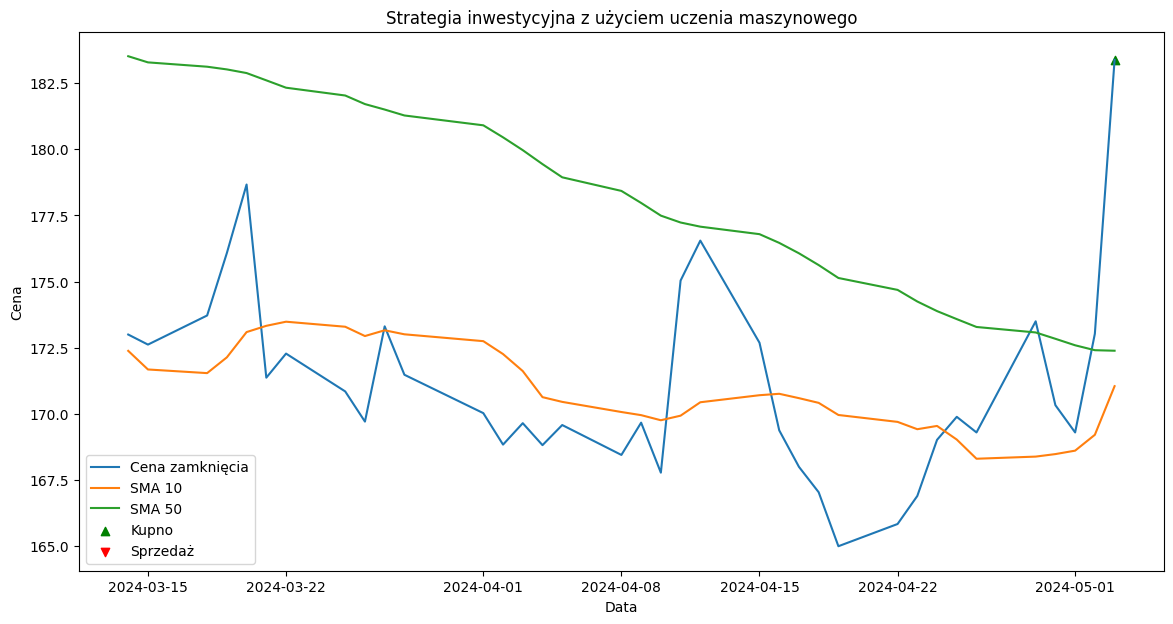

In [10]:
# Wykres zysków i strat
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Close'], label='Cena zamknięcia')
plt.plot(test_data.index, test_data['SMA_10'], label='SMA 10')
plt.plot(test_data.index, test_data['SMA_50'], label='SMA 50')

buy_signals = test_data[test_data['Position'] == 1]
sell_signals = test_data[test_data['Position'] == -1]

plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Kupno')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sprzedaż')

plt.title('Strategia inwestycyjna z użyciem uczenia maszynowego')
plt.xlabel('Data')
plt.ylabel('Cena')
plt.legend()
plt.show()
